In [1]:
import numpy as np
import pandas
from PIL import Image as pilImg
import os 
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
import itertools

1. Підготовка Даних із завантаженого датасета із Англійскими словами
Source: https://www.robots.ox.ac.uk/~vgg/data/text/#sec-synth

Із file_path (шлях до txt файлу із описами картинок) отримує картинки у кількості number
Повертає тільки картинки з текстом розміром від 4 до 12 елементів

Takes the file path of images annotation txt file with the number of images names to be extracted
and returns the list of file names having label length <=12

In [2]:
def Extract_image_names(file_path, number):
    with open(file_path) as file:
        files = file.readlines()
        file.close()
        count = 0
        img_names = []
        for f in files:
            """
            Extract from 'SynthImageDataset./2425/1/115_Lube_45484.jpg 45484' only image lable - Lube
            """
            label = f.split('_')[1]
            if len(label) >= 4 and len(label) <= 12:
                img_names.append(f)
                count += 1
            if count == number:
                break
        images_names=['SynthImageDataset' + x.strip() for x in img_names]
        #Clears date deleting number from end of name
        res_files = []
        for file in images_names:
            main_folder, img_loc, extension = file.split('.')
            extension = extension.split(' ')[0]
            img_file = main_folder + img_loc + '.' + extension
            res_files.append(img_file)
        return res_files

У змінну для навчання записуєм 200000 шляхів до картинок

In [3]:
train_images = Extract_image_names('SynthImageDataset/annotation_train.txt',200000)
train_images[:5]

['SynthImageDataset/2425/1/115_Lube_45484.jpg',
 'SynthImageDataset/2425/1/114_Spencerian_73323.jpg',
 'SynthImageDataset/2425/1/112_CARPENTER_11682.jpg',
 'SynthImageDataset/2425/1/110_savannas_67969.jpg',
 'SynthImageDataset/2425/1/109_unfix_82473.jpg']

In [4]:
train_data = pandas.DataFrame({'ImageName':train_images})
train_data.head()

,ImageName
0,SynthImageDataset/2425/1/115_Lube_45484.jpg
1,SynthImageDataset/2425/1/114_Spencerian_73323.jpg
2,SynthImageDataset/2425/1/112_CARPENTER_11682.jpg
3,SynthImageDataset/2425/1/110_savannas_67969.jpg
4,SynthImageDataset/2425/1/109_unfix_82473.jpg


Із файлів отримуємо назви картинок, які відповідають тексту на картинках

In [5]:
def extract_values(files):
    """
    Given the file names of images, extracts the Values and returns a list of Labels in Upper Case
    """
    txt_labels = []
    for file in files:
        values = file.split('_')[1]
        values = values.upper()
        txt_labels.append(values)
    return txt_labels   


In [6]:
train_values = extract_values(train_images)
#Add to csv Label for Images
train_data['Labels'] = train_values
train_data.head()

,ImageName,Labels
0,SynthImageDataset/2425/1/115_Lube_45484.jpg,LUBE
1,SynthImageDataset/2425/1/114_Spencerian_73323.jpg,SPENCERIAN
2,SynthImageDataset/2425/1/112_CARPENTER_11682.jpg,CARPENTER
3,SynthImageDataset/2425/1/110_savannas_67969.jpg,SAVANNAS
4,SynthImageDataset/2425/1/109_unfix_82473.jpg,UNFIX


Створюємо csv файли із шляхами до картинок і текстом на них

Create Train Data csv file

In [7]:
train_data.to_csv('Train_data.csv')

Validation Data

In [8]:
validation_images = Extract_image_names('SynthImageDataset/annotation_val.txt',12000)
val_data = pandas.DataFrame({'ImageName':validation_images})
Val_values = extract_values(validation_images)
val_data['Labels'] = Val_values
val_data.head()

,ImageName,Labels
0,SynthImageDataset/2697/6/466_MONIKER_49537.jpg,MONIKER
1,SynthImageDataset/2697/6/464_FIRESTORM_29099.jpg,FIRESTORM
2,SynthImageDataset/2697/6/462_Repurchases_64997...,REPURCHASES
3,SynthImageDataset/2697/6/461_PIGTAIL_57575.jpg,PIGTAIL
4,SynthImageDataset/2697/6/460_landladies_43270.jpg,LANDLADIES


In [9]:
val_data.to_csv('Validation_data.csv')

Test Data

In [10]:
test_images = Extract_image_names('SynthImageDataset/annotation_test.txt',15000)
test_data = pandas.DataFrame({'ImageName':test_images})
test_values = extract_values(test_images)
test_data['Labels'] = test_values
test_data.head()

,ImageName,Labels
0,SynthImageDataset/3000/7/182_slinking_71711.jpg,SLINKING
1,SynthImageDataset/3000/7/181_REMODELERS_64541.jpg,REMODELERS
2,SynthImageDataset/3000/7/180_Chronographs_1353...,CHRONOGRAPHS
3,SynthImageDataset/3000/7/179_Impeaching_38222.jpg,IMPEACHING
4,SynthImageDataset/3000/7/177_Loots_45256.jpg,LOOTS


In [11]:
test_data.to_csv('Test_data.csv')

Image Processing

Перетворення картинок у відтінки сірого

Зчитує картинку із файла, перетворює у відтінки сірого і записує у нову папку

In [12]:
def img_store_single_channel(destination_folder, files):
    """
    Takes files, distination folder path and 
    converts the image to single channel gray scale,
    stores the image in the destination folder and returns image destination list
    """
    timer_start = datetime.now()
    destination_list = []
    count = 1
    for file in files:
        #Removing the extra folder structures
        Name = file.split('/')[3]
        img = Name.split('_')[1]
        destination = destination_folder + str(count) + '_' + img + '.jpg'
        cv_img = cv2.imread(file)
        #So extracting image from any 1 channel gives a single channel Grayscale image
        cv_img_sc = cv_img[:, :, 1]
        cv2.imwrite(destination, cv_img_sc)
        destination_list.append(destination)
        count += 1
        if count % 10000 == 0:
            print("Processed Images: ", count)
    print('Time Taken for Processing: ', datetime.now() - timer_start)
    return destination_list

Обробка картинок

Processing Validation Data

Оброблені картинки зберіагаються до папки Val_data

In [13]:
val_data = pandas.read_csv('Validation_data.csv')
val_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
val_files = val_data['ImageName'].values
#os.mkdir('Val_data')
val_dest = img_store_single_channel('Val_data/', val_files)

Processed Images:  10000
Time Taken for Processing:  0:00:27.882640


In [14]:
#Updating Validation Dataframe with new destination file paths
val_data['ImageName'] = val_dest
val_data.head()

,ImageName,Labels
0,Val_data/1_MONIKER.jpg,MONIKER
1,Val_data/2_FIRESTORM.jpg,FIRESTORM
2,Val_data/3_Repurchases.jpg,REPURCHASES
3,Val_data/4_PIGTAIL.jpg,PIGTAIL
4,Val_data/5_landladies.jpg,LANDLADIES


Створення фінального валідаційного датафрему з обробленими картинками

In [15]:
#Saving the updated Validation Dataframe
val_data.to_csv('Validation_Final.csv')

Processing Test Data

In [16]:
test_data = pandas.read_csv('Test_data.csv')
test_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_files = test_data['ImageName'].values
#os.mkdir('Test_data')
test_dest = img_store_single_channel('Test_data/', test_files)

Processed Images:  10000
Time Taken for Processing:  0:00:51.791081


In [17]:
#Updating Test Dataframe with new destination file paths
test_data['ImageName'] = test_dest
test_data.head()

,ImageName,Labels
0,Test_data/1_slinking.jpg,SLINKING
1,Test_data/2_REMODELERS.jpg,REMODELERS
2,Test_data/3_Chronographs.jpg,CHRONOGRAPHS
3,Test_data/4_Impeaching.jpg,IMPEACHING
4,Test_data/5_Loots.jpg,LOOTS


In [18]:
#Saving the updated Test Dataframe
test_data.to_csv('Test_Final.csv')

Processing Train Data

In [19]:
train_data = pandas.read_csv('Train_data.csv')
train_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
train_files = train_data['ImageName'].values
#os.mkdir('Train_data')
train_dest = img_store_single_channel('Train_data/', train_files)

Processed Images:  10000
Processed Images:  20000
Processed Images:  30000
Processed Images:  40000
Processed Images:  50000
Processed Images:  60000
Processed Images:  70000
Processed Images:  80000
Processed Images:  90000
Processed Images:  100000
Processed Images:  110000
Processed Images:  120000
Processed Images:  130000
Processed Images:  140000
Processed Images:  150000
Processed Images:  160000
Processed Images:  170000
Processed Images:  180000
Processed Images:  190000
Processed Images:  200000
Time Taken for Processing:  0:09:07.144117


In [20]:
#Updating Train Dataframe with new destination file paths
train_data['ImageName'] = train_dest
train_data.head()

,ImageName,Labels
0,Train_data/1_Lube.jpg,LUBE
1,Train_data/2_Spencerian.jpg,SPENCERIAN
2,Train_data/3_CARPENTER.jpg,CARPENTER
3,Train_data/4_savannas.jpg,SAVANNAS
4,Train_data/5_unfix.jpg,UNFIX


In [21]:
#Saving the updated Train Dataframe
train_data.to_csv('Train_Final.csv')

Аналіз розміру (розширення) катинок

Image Size Analysis

Зчитує із масиву filenames шляхи до картинок, відкриває кожну і записує у storage_file назву картинки, її висоту та ширину

In [22]:
def Write_Image_Sizes(filenames, storage_file):
    """
    Takes the File names, writes the width and height of images in csv along with file names
    """
    store_file = open(storage_file, 'w+')
    store_file.write("ImageName,Height,Width")
    store_file.write("\n")
    counter = 0
    for file in filenames:
        cv_img = cv2.imread(file)
        #img.shape gives [img_height, img_width, img_channel] take 0 and 1
        store_file.write(str(file) + "," + str(cv_img.shape[0]) + "," + str(cv_img.shape[1]))
        store_file.write("\n")
        counter += 1
        if counter % 10000 == 0:
            print("Processed Images: ", counter)
    store_file.close()

In [23]:
train_data = pandas.read_csv('Train_data.csv')
Write_Image_Sizes(list(train_data['ImageName'].values), 'Train_image_sizes.csv')

Processed Images:  10000
Processed Images:  20000
Processed Images:  30000
Processed Images:  40000
Processed Images:  50000
Processed Images:  60000
Processed Images:  70000
Processed Images:  80000
Processed Images:  90000
Processed Images:  100000
Processed Images:  110000
Processed Images:  120000
Processed Images:  130000
Processed Images:  140000
Processed Images:  150000
Processed Images:  160000
Processed Images:  170000
Processed Images:  180000
Processed Images:  190000
Processed Images:  200000


In [24]:
train_img_size = pandas.read_csv('Train_image_sizes.csv')
train_img_size.describe()

,Height,Width
count,200000.000000,200000.000000
mean,31.038550,115.668015
std,0.333698,39.696249
min,9.000000,1.000000
25%,31.000000,88.000000
50%,31.000000,109.000000
75%,31.000000,136.000000
max,32.000000,608.000000


In [25]:
print("Train Images Height 90 percentile :", np.percentile(train_img_size['Height'].values, 90))
print("Train Images Height 99 percentile :", np.percentile(train_img_size['Height'].values, 99))
print("Train Images Width 90 percentile :", np.percentile(train_img_size['Width'].values, 90))
print("Train Images Width 99 percentile :", np.percentile(train_img_size['Width'].values, 99))

Train Images Height 90 percentile : 31.0
Train Images Height 99 percentile : 32.0
Train Images Width 90 percentile : 167.0
Train Images Width 99 percentile : 240.0


Це показує, що 90 процентиль висоти картинок 31 піксель, 99 процентиль 32 пікселя

А по ширині 90 процентиль 167 пікселів, 99 процентиль 240 пікселів

Графік CDF (акумулююча функція) для висот картинок

In [26]:
def cdf_image_heights(label_len):
    """
    Takes a list of image heights as input and Plots CDF of image heights
    """
    plt.figure(figsize = (10,6))
    count_labels = np.array(label_len)
    counts, bin_edges = np.histogram(count_labels, bins = 8, density = True)
    pdf = counts / (sum(counts))
    cdf = np.cumsum(pdf)
    plt.plot(bin_edges[1:], cdf)
    plt.xlabel('Height of Images', fontsize = 10)
    plt.ylabel('CDF', fontsize = 10)
    plt.title('CDF Plot of Image Height', fontsize = 12)
    plt.show()

Графік CDF (акумулююча функція) для широт картинок

In [27]:
def cdf_image_widths(label_len):
    """
    Takes a list of image widths as input and Plots CDF of image widths
    """
    plt.figure(figsize = (10,6))
    count_labels = np.array(label_len)
    counts, bin_edges = np.histogram(count_labels, bins = 8, density = True)
    pdf = counts / (sum(counts))
    cdf = np.cumsum(pdf)
    plt.plot(bin_edges[1:], cdf)
    plt.xlabel('Width of Images', fontsize=10)
    plt.ylabel('CDF', fontsize=10)
    plt.title('CDF Plot of Image Width', fontsize=12)
    plt.show()

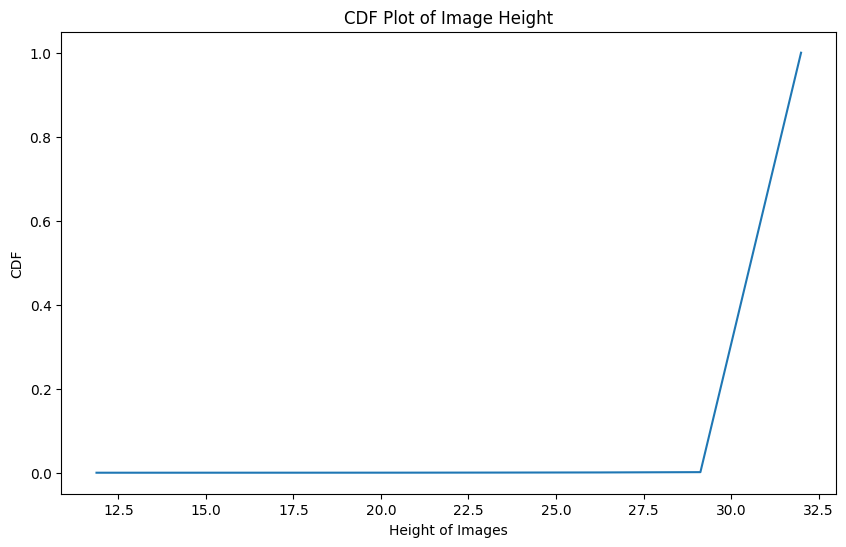

In [28]:
cdf_image_heights(train_img_size['Height'].values)

Цей графік показує, що навчальні картинки більш менш рівномірно розподілені по висоті від 29 до 31 пікселя

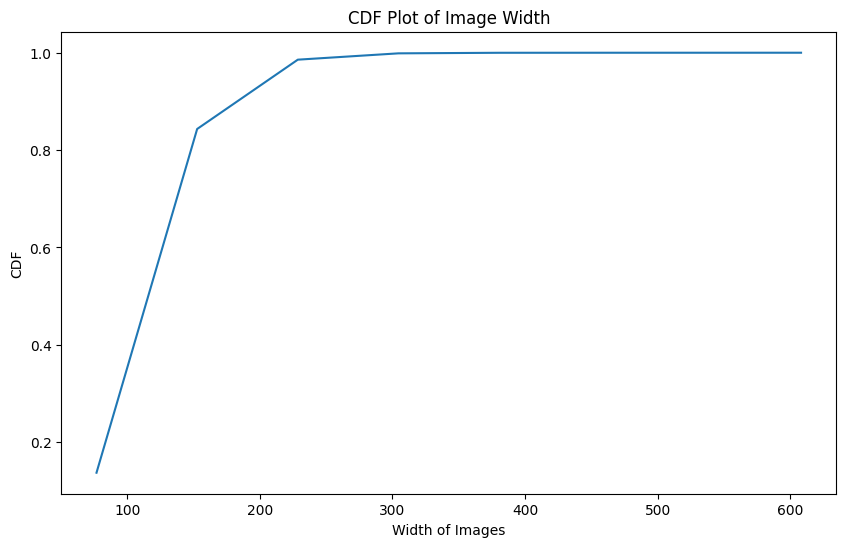

In [29]:
cdf_image_widths(train_img_size['Width'].values)

Цей графік показує, що 85% ширин картинок десь до 170 пікселів, інші 13% до 250 пікселів, і менше 2% це картинки більшої ширини

Враховуючи результати досліждень розміру картинок можна дійти висновку що найкращим розширенням для моделі мало б бути 32х170 пікселів

Utility Functions

In [1]:
import numpy as np
import pandas
from PIL import Image as pilImg
import os 
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
import itertools

In [2]:
import keras
import random
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")

Базові константи

In [3]:
#Letters present in the Label Text
letters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
#image height
img_h = 32
#image width
img_w = 170
#image Channels
img_c = 1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes = len(letters) + 1
batch_size = 64
# considering max length of ground truths labels to be 15
max_length = 15 

Функція необхідна для навчання - перетворює слово на масив із чисел по letters HAT returns [17,10,29]

In [4]:
def encode_words_labels(word):
    """
    Encodes the Ground Truth Labels to a list of Values like eg. HAT returns [17,10,29]
    """
    label_lst = []
    for char in word:
        label_lst.append(letters.find(char)) # keeping 0 for blank and for padding labels
    return label_lst

Протилежна функція, необхідна для тестування мережі - перетворює масив із значенням літер на слово

In [5]:
def words_from_labels(labels):
    """
    converts the list of encoded integer labels to word strings like eg. [17,10,29] returns HAT 
    """
    txt = []
    for ele in labels:
        if ele == len(letters): # last element blank space
            txt.append(" ")
        else:
            txt.append(letters[ele])
    return "".join(txt)

In [6]:
def ctc_loss_function(args):
    """
    CTC loss function takes the values passed from the model returns the CTC loss using Keras Backend ctc_batch_cost function
    """
    y_pred, y_true, input_length, label_length = args 
    # since the first couple outputs of the RNN tend to be garbage we need to discard them, found this from other CRNN approaches
    # I Tried by including these outputs but the results turned out to be very bad and got very low accuracies on prediction 
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)   

Data Generator

Зчитує дані із файлів, та адаптує їх по розміру під мережу

Перемішує дані та ітерується по них

In [7]:
class DataGenerator(keras.callbacks.Callback):
    def __init__(self, img_dirpath, img_w, img_h,
                 batch_size, n, output_labels, max_text_len=15):
        self.img_h = img_h                    #Image Height
        self.img_w = img_w                    #Image Width
        self.batch_size = batch_size          #Batch size of Input
        self.max_text_len = max_text_len      #Maximum Text length of Labels
        self.n = n
        self.img_dir = img_dirpath[:self.n]     # images list
        self.indexes = list(range(self.n))   #List of indices for each image in img_matrix
        self.cur_index = 0                   #Current index which points to image being loaded 
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts =  output_labels[:self.n]                  #List of Ground Truth Label texts

   
    def build_data(self):
        """
        Build The Image Data
        """
        print(self.n, " Image Loading start...")
        for i, img_file in enumerate(self.img_dir):
            img = cv2.imread(img_file)
            img = img[:,:,1]                               #Extracting Single Channel Image
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img / 255
            self.imgs[i, :, :] = img
            if i % 10000 == 0:
                print("Loaded Images: ", i)
           
        print("Number of Texts matches with Total Number of Images :", len(self.texts) == self.n)
        print(self.n, " Image Loading finish...")


    def next_data(self): 
        """
        Returns image and text data pointed by the current index
        """
        self.cur_index += 1
        #If current index becomes more than the number of images, make current index 0 
        #and shuffle the indices list for random picking of image and text data
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):
        """
        Creates a batch of images images and text data equal to the batch_size,
        computes the parameters needed for CTC and returns the inputs to the Model
        """
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])  #Single channel Gray Size Scale images for input
            #Initilizing with -1 to aid for padding labels of different lengths
            Y_data = np.ones([self.batch_size, self.max_text_len])* -1        #Text labels for input
            #input_length for CTC which is the number of time-steps of the RNN output
            input_length = np.ones((self.batch_size, 1)) * 40
            label_length = np.zeros((self.batch_size, 1))                   #label length for CTC
            source_str = []                                                 #List to store Ground Truth Labels
            for i in range(self.batch_size):
                img, text = self.next_data() #getting the image and text data pointed by current index
                img = img.T #taking transpose of image
                img = np.expand_dims(img, -1)  #expanding image to have a single channel
                X_data[i] = img
                label = encode_words_labels(text) # encoding label text to integer list and storing in temp label variable
                lbl_len=len(label)
                Y_data[i, 0:lbl_len] = label #Storing the label till its length and padding others
                label_length[i] = len(label)
                source_str.append(text) #storing Ground Truth Labels which will be accessed as reference for calculating metrics
            
            #Preparing the input for the Model
            inputs = {
                'img_input': X_data,  
                'ground_truth_labels': Y_data,  
                'input_length': input_length,  
                'label_length': label_length,
                'source_str': source_str  # used for visualization only
            }
            #Preparing output for the Model and intializing to zeros
            outputs = {'ctc': np.zeros([self.batch_size])}  
            yield (inputs, outputs) # Return the Prepared input and output to the Model

Model

In [31]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense, MaxPooling2D
from keras.layers import Activation, Bidirectional
from keras.layers import BatchNormalization, Dropout
from keras.layers import Lambda
from keras.layers import Reshape
from keras.layers import add, concatenate
from keras.layers import Reshape
from keras.models import Model
from keras.layers import LSTM, GRU
import tensorflow as tf

In [32]:
def Image_text_recogniser_model(stage, drop_out_rate = 0.35):
    """
    Builds the model by taking in the stage variable which specifes the stage,
    if the stage is training: model takes inputs required for computing ctc_batch_cost function
    else : model takes input as images which is used for prediction
    """
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
       
    model_input = Input(shape = input_shape, name = 'img_input', dtype = 'float32')

    # Convolution layer 
    model = Conv2D(64, (3, 3), padding = 'same', name = 'conv1', kernel_initializer = 'he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size = (2, 2), name = 'max1')(model) 

    model = Conv2D(128, (3, 3), padding = 'same', name = 'conv2', kernel_initializer = 'he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size = (2, 2), name = 'max2')(model) 

    model = Conv2D(256, (3, 3), padding = 'same', name = 'conv3', kernel_initializer = 'he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding = 'same', name = 'conv4', kernel_initializer = 'he_normal')(model)
    model = Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size = (1, 2), name = 'max3')(model)  

    model = Conv2D(512, (3, 3), padding = 'same', name = 'conv5', kernel_initializer = 'he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding = 'same', name = 'conv6')(model)
    model = Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size = (1, 2), name = 'max4')(model)

    model = Conv2D(512, (2, 2), padding = 'same', kernel_initializer = 'he_normal', name = 'con7')(model)
    model = Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    # CNN to RNN
    model = Reshape(target_shape = ((42, 1024)), name = 'reshape')(model)  
    model = Dense(64, activation = 'relu', kernel_initializer = 'he_normal', name = 'dense1')(model)  

    # RNN layer
    model = Bidirectional(LSTM(256, return_sequences = True, kernel_initializer = 'he_normal'), merge_mode = 'sum')(model)
    model = Bidirectional(LSTM(256, return_sequences = True, kernel_initializer = 'he_normal'), merge_mode = 'concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer = 'he_normal',name = 'dense2')(model) 
    y_pred = Activation('softmax', name = 'softmax')(model)

    
    labels = Input(name = 'ground_truth_labels', shape = [max_length], dtype = 'float32') 
    input_length = Input(name = 'input_length', shape = [1], dtype = 'int64') 
    label_length = Input(name = 'label_length', shape = [1], dtype = 'int64') 

    #CTC loss function
    loss_out = Lambda(ctc_loss_function, output_shape = (1,), name = 'ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    if stage == 'train':
        return model_input, y_pred, Model(inputs = [model_input, labels, input_length, label_length], outputs = loss_out)
    else:
        return Model(inputs = [model_input], outputs = y_pred)     

In [33]:
model_input, y_pred, img_text_recog = Image_text_recogniser_model('train')
img_text_recog.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 170, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 170, 32, 64)  640         ['img_input[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 170, 32, 64)  256        ['conv1[0][0]']                  
 rmalization)                                                                                     
                                                                                            

Збереження моделі

In [34]:
model_to_save = Image_text_recogniser_model('save')
config = model_to_save.to_json()
with open("modelBiggest.json", "w") as outfile:
    outfile.write(config)

Створення callback

In [35]:
# used for visualization
# it is a keras backend function used to capture the model ouputs so that it can be used for decoding and calculating metrics
test_func = K.function([model_input], [y_pred])

In [36]:
def decode_batch(test_func, word_batch):
    """
    Takes the Batch of Predictions and decodes the Predictions by Best Path Decoding and Returns the Output
    """
    out = test_func([word_batch])[0] #returns the predicted output matrix of the model
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = words_from_labels(out_best)
        ret.append(outstr)
    return ret

In [37]:
def accuracies(actual_labels,predicted_labels,is_train):
    """
    Takes a List of Actual Outputs, predicted Outputs and returns their accuracy and letter accuracy across
    all the labels in the list
    """
    accuracy = 0
    letter_acc = 0
    letter_cnt = 0
    count = 0
    for i in range(len(actual_labels)):
        predicted_output = predicted_labels[i]
        actual_output = actual_labels[i]
        count += 1
        for j in range(min(len(predicted_output), len(actual_output))):
            if predicted_output[j] == actual_output[j]:
                letter_acc += 1
        letter_cnt += max(len(predicted_output),len(actual_output))
        if actual_output == predicted_output:
            accuracy += 1
    final_accuracy = np.round((accuracy/len(actual_labels))*100, 2)
    final_letter_acc = np.round((letter_acc/letter_cnt)*100, 2)
    return final_accuracy, final_letter_acc

In [14]:
class VizCallback(keras.callbacks.Callback):
    """
    The Custom Callback created for printing the Accuracy and Letter Accuracy Metrics at the End of Each Epoch
    """

    def __init__(self, test_func, text_img_gen,is_train,acc_compute_batches):
        self.test_func = test_func
        self.text_img_gen = text_img_gen
        self.is_train = is_train                #used to indicate whether the callback is called to for Train or Validation Data
        self.acc_batches = acc_compute_batches  # Number of Batches for which the metrics are computed typically equal to steps/epoch

    def show_accuracy_metrics(self,num_batches):
        """
        Calculates the accuracy and letter accuracy for each batch of inputs, 
        and prints the avarage accuracy and letter accuracy across all the batches
        """
        accuracy = 0
        letter_accuracy = 0
        batches_cnt = num_batches
        while batches_cnt > 0:
            word_batch = next(self.text_img_gen)[0]   #Gets the next batch from the Data generator
            decoded_res = decode_batch(self.test_func,word_batch['img_input'])
            actual_res = word_batch['source_str']
            acc, let_acc = accuracies(actual_res, decoded_res, self.is_train)
            accuracy += acc
            letter_accuracy += let_acc
            batches_cnt -= 1
        accuracy = accuracy/num_batches
        letter_accuracy = letter_accuracy/num_batches
        if self.is_train:
            print("Train Average Accuracy of " + str(num_batches) + " Batches: ", np.round(accuracy, 2), " %")
            print("Train Average Letter Accuracy of " + str(num_batches) + " Batches: ", np.round(letter_accuracy, 2), " %")
        else:
            print("Validation Average Accuracy of " + str(num_batches) + " Batches: ", np.round(accuracy, 2), " %")
            print("Validation Average Letter Accuracy of " + str(num_batches) + " Batches: ", np.round(letter_accuracy, 2), " %")
            
        
    def on_epoch_end(self, epoch, logs={}):
        self.show_accuracy_metrics(self.acc_batches)

In [38]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
early_stop = EarlyStopping(monitor = 'val_loss', patience=2, restore_best_weights=True)
#del  save_weights_only=True,
model_chk_pt = ModelCheckpoint('BiggestModel.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1, mode = 'auto')

Зчитуєм дані

Train data

In [16]:
train_data = pandas.read_csv('Train_Final.csv')

In [17]:
train_labels = [str(x) for x in train_data['Labels'].values]
train_paths = [str(x) for x in train_data['ImageName'].values]

У датасеті не усі папки заповнені, є серед них пусті де мали б бути картинки. Ці елементи прописані у файлах, а на практиці їх не існує

Такі елементи потрібно проігнорувати

In [18]:
train_nan_cnt = 0
train_nan_replaced = False
for i in range(len(train_labels)):
    if train_labels[i] == 'nan':
        train_labels[i] = 'NULL'
        train_nan_replaced = True
        train_nan_cnt += 1
train_nan_cnt

3

Validation data

In [19]:
validation_data = pandas.read_csv('Validation_Final.csv')

In [20]:
validation_labels = [str(x) for x in validation_data['Labels'].values]
validation_paths = [str(x) for x in validation_data['ImageName'].values]

In [21]:
validation_nan_cnt = 0
validation_nan_replaced = False
for i in range(len(validation_labels)):
    if validation_labels[i] == 'nan':
        validation_labels[i] = 'NULL'
        validation_nan_replaced = True
        validation_nan_cnt += 1
validation_nan_cnt

0

In [22]:
train_gene = DataGenerator(train_paths, img_w, img_h, batch_size, 200000, train_labels)

In [23]:
train_gene.build_data()

200000  Image Loading start...
Loaded Images:  0
Loaded Images:  10000
Loaded Images:  20000
Loaded Images:  30000
Loaded Images:  40000
Loaded Images:  50000
Loaded Images:  60000
Loaded Images:  70000
Loaded Images:  80000
Loaded Images:  90000
Loaded Images:  100000
Loaded Images:  110000
Loaded Images:  120000
Loaded Images:  130000
Loaded Images:  140000
Loaded Images:  150000
Loaded Images:  160000
Loaded Images:  170000
Loaded Images:  180000
Loaded Images:  190000
Number of Texts matches with Total Number of Images : True
200000  Image Loading finish...


In [24]:
train_num_batches = int(train_gene.n/batch_size)
viz_cb_train = VizCallback(test_func, train_gene.next_batch(), True, train_num_batches)

In [25]:
val_gen = DataGenerator(validation_paths, img_w, img_h, batch_size, 12000, validation_labels)

In [26]:
val_gen.build_data()

12000  Image Loading start...
Loaded Images:  0
Loaded Images:  10000
Number of Texts matches with Total Number of Images : True
12000  Image Loading finish...


In [27]:
val_num_batches = int(val_gen.n / batch_size)
viz_cb_val = VizCallback(test_func, val_gen.next_batch(), False, val_num_batches)

Optimizer

In [40]:
from keras import optimizers
adam = optimizers.Adam()
#loss ={'ctc': lambda y_true, y_pred: y_pred}
img_text_recog.compile(loss = {'ctc': lambda y_true, y_pred: y_pred}, optimizer = adam)

Train

First Fit

In [42]:
img_text_recog.fit(train_gene.next_batch(),
                    steps_per_epoch = int(train_gene.n / batch_size),
                    epochs = 1,
                    callbacks=[viz_cb_train,viz_cb_val,train_gene,val_gen,early_stop,model_chk_pt],
                    validation_data = val_gen.next_batch(),
                    validation_steps = int(val_gen.n / batch_size))

   4/3125 [..............................] - ETA: 2:58:25 - loss: 2.0383

KeyboardInterrupt: 

In [32]:
img_text_recog.save('model2_run_weights.h5')

Next Fit

In [43]:
img_text_recog.load_weights('BiggestModel.03-1.66.h5')

In [44]:
img_text_recog.fit(train_gene.next_batch(),
                    steps_per_epoch = int(train_gene.n / batch_size),
                    epochs = 1,
                    callbacks=[viz_cb_train,viz_cb_val,train_gene,val_gen,early_stop,model_chk_pt],
                    validation_data = val_gen.next_batch(),
                    validation_steps = int(val_gen.n / batch_size))

3125/3125 [==============================] - ETA: 0s - loss: 1.3936Train Average Accuracy of 3125 Batches:  0.0  %
Train Average Letter Accuracy of 3125 Batches:  1.66  %
Validation Average Accuracy of 187 Batches:  0.0  %
Validation Average Letter Accuracy of 187 Batches:  1.68  %

Epoch 1: val_loss improved from 1.65879 to 1.43956, saving model to BiggestModel.01-1.44.h5
3125/3125 [==============================] - 17472s 6s/step - loss: 1.3936 - val_loss: 1.4396
